In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [2]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

In [3]:
STOPWORDS = set(stopwords.words('english'))

## Load the dataset

In [2]:
# !unzip /content/drive/MyDrive/Movie_Genre_Classfication/archive.zip

Archive:  /content/drive/MyDrive/Movie_Genre_Classfication/archive.zip
  inflating: Genre Classification Dataset/description.txt  
  inflating: Genre Classification Dataset/test_data.txt  
  inflating: Genre Classification Dataset/test_data_solution.txt  
  inflating: Genre Classification Dataset/train_data.txt  


In [39]:
# Train data
train_path = './Data/train_data.txt'
train_data = pd.read_csv(train_path,  sep=':::',engine='python',names=['Title','Genre','Description'])

# Test data
test_path='./Data/test_data.txt'
test_data=pd.read_csv( test_path , sep=':::',engine='python',names=['Title','Description'])

# Test data with genre labels
test_labels_path = './Data/test_data_solution.txt'
test_labels_data=pd.read_csv(test_labels_path, sep=':::',engine='python',names=['Title','Genre','Description'])


# Merge Train and Test data with genre labels

data = pd.concat((train_data, test_labels_data))

data.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [6]:
data.shape

(108414, 3)

### Data visualization

In [14]:
genre = data['Genre'].value_counts()
fig = px.bar(genre, x=genre.index, y=genre, title='Genre Distribution')
fig.update_layout(xaxis_title='Genre', yaxis_title='Count')
fig.show()

In [40]:
data['Genre'].unique()


array([' drama ', ' thriller ', ' adult ', ' documentary ', ' comedy ',
       ' crime ', ' reality-tv ', ' horror ', ' sport ', ' animation ',
       ' action ', ' fantasy ', ' short ', ' sci-fi ', ' music ',
       ' adventure ', ' talk-show ', ' western ', ' family ', ' mystery ',
       ' history ', ' news ', ' biography ', ' romance ', ' game-show ',
       ' musical ', ' war '], dtype=object)

In [41]:
# Removed the white spaces
data['Genre'] = data['Genre'].str.strip()
data['Genre'].unique()

array(['drama', 'thriller', 'adult', 'documentary', 'comedy', 'crime',
       'reality-tv', 'horror', 'sport', 'animation', 'action', 'fantasy',
       'short', 'sci-fi', 'music', 'adventure', 'talk-show', 'western',
       'family', 'mystery', 'history', 'news', 'biography', 'romance',
       'game-show', 'musical', 'war'], dtype=object)

In [17]:
data.shape

(108414, 3)

In [18]:
def get_top_n_bigram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

In [19]:
top_30_unigrams = get_top_n_bigram(data.Description, ngram=1, top=30)
top_30_bigrams = get_top_n_bigram(data.Description, ngram=2, top=30)
top_30_trigrams = get_top_n_bigram(data.Description, ngram=3, top=30)

In [26]:
df1 = pd.DataFrame(top_30_unigrams, columns = ['unigram' , 'count'])
fig = px.bar(df1, x='unigram', y='count', title='Top 30 Unigrams', color='unigram')
fig.update_layout(xaxis_title='Unigram', yaxis_title='Count')
fig.update_xaxes(tickangle=80)

fig.show()

In [28]:
df1 = pd.DataFrame(top_30_bigrams, columns = ['bigram' , 'count'])
fig = px.bar(df1, x='bigram', y='count', title='Top 30 Bigrams', color='bigram')
fig.update_layout(xaxis_title='Bigram', yaxis_title='Count')
fig.update_xaxes(tickangle=80)

fig.show()

In [29]:
df1 = pd.DataFrame(top_30_trigrams, columns = ['trigram' , 'count'])
fig = px.bar(df1, x='trigram', y='count', title='Top 30 Trigrams', color='trigram')
fig.update_layout(xaxis_title='Trigram', yaxis_title='Count')
fig.update_xaxes(tickangle=80)

fig.show()

### Preprocessing

In [44]:
# Function to map POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'  # Adjective
    elif tag.startswith('V'):
        return 'v'  # Verb
    elif tag.startswith('N'):
        return 'n'  # Noun
    elif tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  # Default to noun if not found

def clean_text(text):
    # Tokenize the text
    words = word_tokenize(text)

    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Get parts-of-speech tags for words
    tagged_words = pos_tag(words)

    # Remove numbers, lowercase words, remove stopwords, and lemmatize based on POS tags
    words = [lemmatizer.lemmatize(word.lower(), pos=get_wordnet_pos(tag))
             for word, tag in tagged_words
             if word.isalpha() and word.lower() not in STOPWORDS]

    # Join the cleaned words back into a single string
    cleaned_text = ' '.join(words)

    return cleaned_text

# def clean_text(text):
#     # Tokenize the text
#     words = word_tokenize(text)

#     # Initialize stopwords and lemmatizer
#     lemmatizer = WordNetLemmatizer()

#     # Remove numbers, lowercase words, remove stopwords, and lemmatize
#     words = [lemmatizer.lemmatize(word.lower()) for word in words if word.isalpha() and word.lower() not in STOPWORDS]

#     # Join the cleaned words back into a single string
#     cleaned_text = ' '.join(words)

#     return cleaned_text

In [45]:
clean_text('I love the loving thing of lovers, lovely, adorable, caring, liking, daring, wasting')

'love loving thing lover lovely adorable caring liking dare waste'

Uncomment the following lines of code for preprocessing the data for first time.

In [46]:
# data['description_cleaned'] = data['Description'].apply(clean_text)

In [47]:
# data = data.drop(['Title','Description'], axis=1)
# data.head()

,Genre,description_cleaned
1,drama,listen conversation doctor parent oscar learn ...
2,thriller,brother sister past incestuous relationship cu...
3,adult,bus empty student field trip museum natural hi...
4,drama,help unemployed father make ends meet edith tw...
5,drama,film title refers body ground zero also state ...


In [48]:
# Save the preprocessed data to avoid re-processing if session is lost.
data.to_csv('./Data/pre_processed_data.csv')


data = pd.read_csv('./Data/pre_processed_data.csv')
data = data.drop(['Unnamed: 0'], axis=1)

In [49]:
data.shape

(108414, 2)

In [50]:
data

,Genre,description_cleaned
0,drama,listen conversation doctor parent oscar learn ...
1,thriller,brother sister past incestuous relationship cu...
2,adult,bus empty student field trip museum natural hi...
3,drama,help unemployed father make ends meet edith tw...
4,drama,film title refers body ground zero also state ...
...,...,...
108409,horror,cover multiple genre tale light dark anthology...
108410,western,alice cora munro attempt find father british o...
108411,adult,movie year making oliver twist artful dodger f...
108412,drama,popular mysterious rock mike mallard askew bro...


In [7]:
# Group the similar genres
def make_genre_groups(df):
    # Replace 'biography', 'history', and 'news' with 'documentary'
    df['Genre'].replace(['biography', 'history', 'news'], 'documentary', inplace=True)

    # Replace 'mystery' and 'crime' with 'thriller'
    df['Genre'].replace(['mystery', 'crime'], 'thriller', inplace=True)

    # Replace 'fantasy' with 'adventure'
    df['Genre'].replace('fantasy', 'adventure', inplace=True)

    # Replace 'family' with 'comedy'
    df['Genre'].replace('family', 'comedy', inplace=True)

    # Replace 'reality-tv', 'game-show', 'talk-show' with 'tv-show'
    df['Genre'].replace(['reality-tv', 'game-show', 'talk-show'], 'tv-show', inplace=True)

    # Group remaining genres into 'other'
    other_genres = ['short', 'western', 'music', 'animation', 'sport', 'musical', 'war']
    df.loc[df['Genre'].isin(other_genres), 'Genre'] = 'other'

    return df

In [51]:
train_df = make_genre_groups(data.copy())


In [53]:

train_df

,Genre,description_cleaned
0,drama,listen conversation doctor parent oscar learn ...
1,thriller,brother sister past incestuous relationship cu...
2,adult,bus empty student field trip museum natural hi...
3,drama,help unemployed father make ends meet edith tw...
4,drama,film title refers body ground zero also state ...
...,...,...
108409,horror,cover multiple genre tale light dark anthology...
108410,other,alice cora munro attempt find father british o...
108411,adult,movie year making oliver twist artful dodger f...
108412,drama,popular mysterious rock mike mallard askew bro...


In [54]:
genre = train_df['Genre'].value_counts()
fig = px.bar(genre, x=genre.index, y=genre, title='Genre Distribution', color=genre.index)
fig.update_layout(xaxis_title='Genre', yaxis_title='Count')
fig.show()

### Vectorize

In [55]:
# Using unigrams, bigrams and trigrams(ngram_range) and 6000 features
tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, ngram_range=(1, 3), max_features=6000)

In [56]:
tfidf_matrix = tfidf_vectorizer.fit_transform(train_df.description_cleaned)

In [57]:
tfidf_vectorizer.get_feature_names_out()

array(['aaron', 'abandon', 'abandoned', ..., 'zombie', 'zone', 'zoo'],
      dtype=object)

In [58]:
train_tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [59]:
train_df[:1]

,Genre,description_cleaned
0,drama,listen conversation doctor parent oscar learn ...


In [60]:
pd.set_option('display.max_columns', 3000)
train_tfidf_df[:1]

,aaron,abandon,abandoned,abc,abduct,abduction,ability,able,aboard,aboriginal,abortion,abroad,absence,absent,absolute,absolutely,abstract,absurd,abuse,abusive,academic,academy,accept,acceptance,access,accident,accidental,accidentally,acclaim,acclaimed,accompany,accomplish,accord,account,accountant,accuse,ace,achieve,achievement,acknowledge,acquaintance,acquire,across,across country,act,acting,action,active,activism,activist,activity,actor,actress,actual,actually,ad,adam,adapt,adaptation,add,addict,addiction,addition,additional,address,adjust,administration,admire,admirer,admit,adolescence,adolescent,adopt,adoption,adore,adrian,adult,adulthood,advance,advanced,advantage,adventure,adventurer,adventurous,adversity,advertising,advice,advise,advocate,aesthetic,affair,affect,affection,afford,afghanistan,afraid,africa,african,african american,aftermath,afternoon,afterwards,age,agency,agenda,agent,aggressive,agnes,ago,agree,agreement,agricultural,ahead,ai,aid,ail,aim,air,air force,aircraft,aire,airline,airplane,airport,ajay,aka,al,alabama,alan,alarm,alaska,albert,alberto,album,alcohol,alcoholic,alex,alexander,alexis,alfred,ali,alice,alien,alienate,alike,alison,alive,allan,allen,alley,alliance,allison,allow,ally,almost,alone,along,along way,alongside,already,also,also feature,also find,also get,also include,also know,also show,alter,alternate,alternative,although,always,alzheimer,amanda,amar,amateur,amaze,amazing,amazon,ambassador,amber,ambition,ambitious,ambush,america,american,american dream,amid,amidst,among,among others,amongst,amount,amsterdam,amuse,amy,ana,analysis,analyze,ancestor,ancestral,anchor,ancient,anderson,andrea,andrew,andy,angel,angela,angeles,angelo,anger,angle,angry,animal,animate,animated,animation,anita,ann,anna,anne,annie,anniversary,announce,annoy,annual,anonymous,another,another man,another woman,answer,answer question,anthology,anthony,antic,anticipate,antique,anton,antonio,anxiety,anybody,anymore,anyone,anything,anyway,anywhere,apart,apartment,apartment building,apocalypse,apparent,apparently,appeal,appear,appearance,apple,apply,appoint,appreciate,apprentice,approach,appropriate,approve,april,arab,archaeologist,architect,architecture,archival,archival footage,archive,archive footage,arctic,area,arena,argentina,argue,argument,arise,arizona,arjun,arm,armed,armenian,army,arnold,around,around globe,around world,arrange,arrangement,array,arrest,arrival,arrive,arrives,arrogant,art,art form,arthur,article,artifact,artificial,artist,artistic,artwork,ash,ashley,asia,asian,aside,ask,ask question,asleep,aspect,aspiration,aspire,aspiring,assassin,assassinate,assassination,assault,assemble,assign,assignment,assist,assistance,assistant,associate,association,assume,astronaut,asylum,athens,athlete,atlanta,atlantic,atmosphere,attach,attack,attempt,attempt find,attempt make,attend,attendant,attention,attitude,attorney,attract,attraction,attractive,au,auction,audience,audio,audition,august,aunt,austin,australia,australian,austria,austrian,authentic,author,authority,autism,auto,automobile,autumn,available,avenge,average,avoid,await,awake,awaken,awakening,award,award win,aware,awareness,away,away home,awkward,awry,az,babe,baby,bachelor,back,back home,back life,back time,back together,backdrop,background,backstage,backyard,bad,bad guy,badly,bag,bailey,baker,balance,ball,ballet,baltimore,ban,band,bandit,bang,bank,banker,bar,barbara,barber,barcelona,bare,barely,bargain,barn,barney,baron,barrier,barry,bartender,base,base true,base true story,baseball,basement,basic,basis,basketball,bass,bat,bath,bathroom,battle,battlefield,bay,bbc,beach,bear,beast,beat,beautiful,beautiful girl,beautiful woman,beautiful young,beautifully,beauty,become,become clear,become famous,become first,become friend,become increasingly,become involve,become one,become part,becomes,bed,bedroom,bee,beer,befriend,beg,begin,beginning,behave,behavior,behaviour,behind,behind scene,beijing,being,belgium,belief,believe,bell,belle,belong,belonging,beloved,belt,ben,bend,bene

In [61]:
# Corresponding words found in the datapoint has weights and rest are 0. 
# Noitce how word 'oscar' has more weight as it is less common.
train_tfidf_df[:1]['listen'], train_tfidf_df[:1]['doctor'], train_tfidf_df[:1]['oscar']  

(0    0.154808
 Name: listen, dtype: float64,
 0    0.124852
 Name: doctor, dtype: float64,
 0    0.354894
 Name: oscar, dtype: float64)

In [62]:
## Encode the labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df['Genre'])

In [63]:
y

array([ 5, 10,  1, ...,  1,  5,  5])

In [64]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping

{'action': 0,
 'adult': 1,
 'adventure': 2,
 'comedy': 3,
 'documentary': 4,
 'drama': 5,
 'horror': 6,
 'other': 7,
 'romance': 8,
 'sci-fi': 9,
 'thriller': 10,
 'tv-show': 11}

### Train test split

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_tfidf_df, y, test_size=0.3, random_state=42, stratify=y)

In [83]:
X_train.shape, X_test.shape

((75889, 6000), (32525, 6000))

In [93]:
# Make a balanced test data by undersampling. 
from imblearn.under_sampling import RandomUnderSampler

samples_per_class = {
    4: 1000,
    5: 1000,
    3: 1000,
    7: 1000,
    # 10: 1000,
    # 6: 1000,
}

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy=samples_per_class, random_state=42)

# fit and apply the transform
X_bal_test, y_bal_test = undersample.fit_resample(X_test, y_test)

In [94]:
print('Before')
print(pd.DataFrame(y_test).value_counts())
print('After')
print(pd.DataFrame(y_bal_test).value_counts())

Before
4     8271
5     8168
3     4938
7     4904
10    1448
6     1322
11     881
0      789
2      659
8      403
9      388
1      354
Name: count, dtype: int64
After
10    1448
6     1322
3     1000
4     1000
5     1000
7     1000
11     881
0      789
2      659
8      403
9      388
1      354
Name: count, dtype: int64


In [32]:
from sklearn.metrics import *
def evaluate(test, pred):
    accuracy = accuracy_score(test, pred)
    cf_report = classification_report(test, pred, target_names=label_encoder.classes_)
    precision = precision_score(test, pred, average='macro')
    recall = recall_score(test, pred, average='macro')
    f1 = f1_score(test, pred, average='macro')


    print(cf_report)
    print('Accuracy', accuracy)
    print('Precision', precision)
    print('Recall', recall)
    print('F1-Score', f1)

In [86]:
# Greater weight to minority classes

from sklearn.utils import class_weight
import numpy as np
class_weights = list(class_weight.compute_class_weight(class_weight='balanced',
                                             classes = np.unique(y),
                                             y = y))

In [87]:
class_weights

[3.436477748193229,
 7.65635593220339,
 4.115945330296127,
 0.548876063183475,
 0.3277050310130944,
 0.3318457300275482,
 2.0495689655172415,
 0.5526702147182969,
 6.722098214285714,
 6.987238979118329,
 1.871271748135874,
 3.0771457765667574]

In [88]:
weights = np.ones(X_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    weights[i] = class_weights[val]

weights

array([2.04956897, 0.32770503, 0.54887606, ..., 0.54887606, 3.43647775,
       4.11594533])

In [42]:
# Convert the weights into a dict object

weights_dict = {}

for index, weight in enumerate(class_weights):
    weights_dict[index] = weight

weights_dict

{0: 3.436477748193229,
 1: 7.65635593220339,
 2: 4.115945330296127,
 3: 0.548876063183475,
 4: 0.3277050310130944,
 5: 0.3318457300275482,
 6: 2.0495689655172415,
 7: 0.5526702147182969,
 8: 6.722098214285714,
 9: 6.987238979118329,
 10: 1.871271748135874,
 11: 3.0771457765667574}

### Model Training


In [89]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42, solver='liblinear', n_jobs=-1)
log_reg.fit(X_train, y_train, sample_weight=weights)                
# weights are passes as argument. Without weights, F1-Scores plumets. Try training without weights

/opt/homebrew/Caskroom/miniforge/base/envs/Tensorflow_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.



LogisticRegression(n_jobs=-1, random_state=42, solver='liblinear')

In [72]:
log_reg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [91]:
# Predictions on imbalanced test data
lr_pred = log_reg.predict(X_test)
evaluate(y_test, lr_pred)


              precision    recall  f1-score   support

      action       0.28      0.52      0.36       789
       adult       0.28      0.66      0.40       354
   adventure       0.20      0.43      0.28       659
      comedy       0.60      0.50      0.54      4938
 documentary       0.79      0.70      0.74      8271
       drama       0.69      0.45      0.54      8168
      horror       0.55      0.70      0.61      1322
       other       0.54      0.42      0.47      4904
     romance       0.10      0.45      0.17       403
      sci-fi       0.25      0.58      0.35       388
    thriller       0.32      0.45      0.37      1448
     tv-show       0.33      0.70      0.44       881

    accuracy                           0.54     32525
   macro avg       0.41      0.55      0.44     32525
weighted avg       0.61      0.54      0.56     32525

Accuracy 0.5380169100691775
Precision 0.41031931029514745
Recall 0.5462495722581615
F1-Score 0.4402361255901259


In [95]:
# Prediction on slightly balanced test data
lr_pred_bal = log_reg.predict(X_bal_test)
evaluate(y_bal_test, lr_pred_bal)

              precision    recall  f1-score   support

      action       0.50      0.52      0.51       789
       adult       0.55      0.66      0.60       354
   adventure       0.44      0.43      0.43       659
      comedy       0.49      0.49      0.49      1000
 documentary       0.64      0.73      0.68      1000
       drama       0.44      0.45      0.44      1000
      horror       0.72      0.70      0.71      1322
       other       0.49      0.41      0.45      1000
     romance       0.37      0.45      0.40       403
      sci-fi       0.45      0.58      0.51       388
    thriller       0.59      0.45      0.51      1448
     tv-show       0.66      0.70      0.68       881

    accuracy                           0.55     10244
   macro avg       0.53      0.55      0.53     10244
weighted avg       0.55      0.55      0.55     10244

Accuracy 0.5485162046075752
Precision 0.5273973264589791
Recall 0.5484624356046658
F1-Score 0.5349963219221372


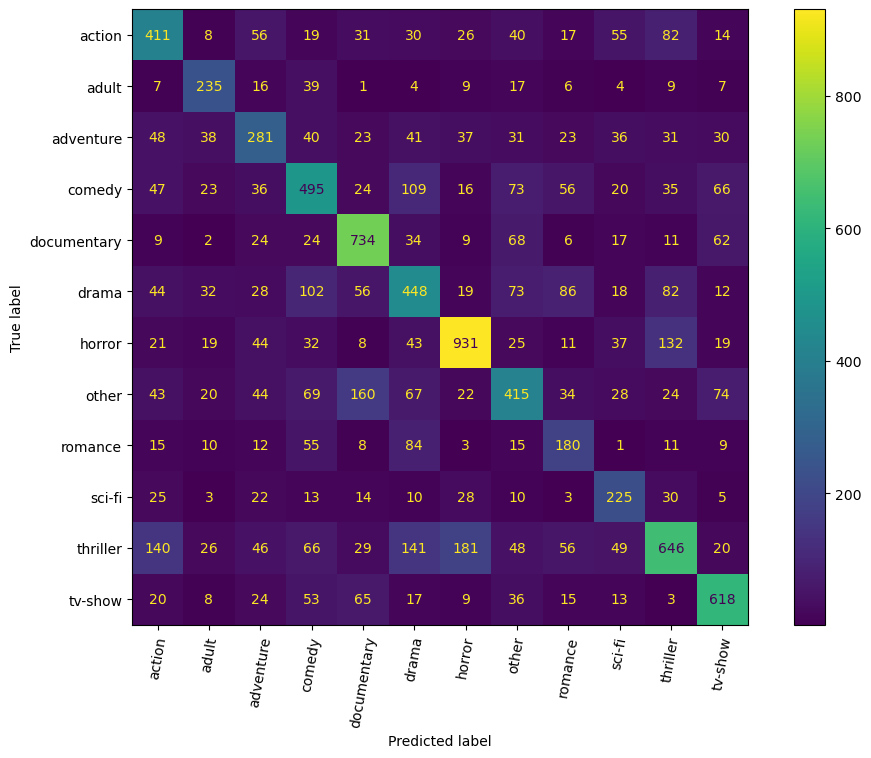

In [97]:
fig, ax = plt.subplots(figsize=(12, 8))
    # Create the confusion matrix
cm = confusion_matrix(y_bal_test, lr_pred_bal)
cmp = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
cmp.plot(ax=ax)
plt.xticks(rotation=80)

plt.show()


In [75]:
classes = label_encoder.classes_
def test_model(data, model):
  # Apply clean_text function to each text in the array using list comprehension
  cleaned_texts = [clean_text(text) for text in data]
  tfidf_matrix = tfidf_vectorizer.transform(cleaned_texts)
  train_tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
  # lr_pred = model.predict(train_tfidf_df)
  predicted_probs = model.predict_proba(train_tfidf_df)

  # Find the indices of the highest and second-highest probabilities for each prediction
  top_classes = np.argmax(predicted_probs, axis=1)  # Highest probability class index
  predicted_probs_copy = np.copy(predicted_probs)
  predicted_probs_copy[np.arange(len(predicted_probs_copy)), top_classes] = -1  # Set top class probability to -1
  second_top_classes = np.argmax(predicted_probs_copy, axis=1)  # Second highest probability class index
  
  res = []
  # Display the highest and second-highest probability classes
  for i, (top_class, second_top_class) in enumerate(zip(top_classes, second_top_classes), start=1):
    res.append(classes[top_class]+'/'+classes[second_top_class])

  return res


### Perform tests on some random data

In [76]:


data = [
    "On their flight from New York to London, Hadley and Oliver fall in love with each other. However, they lose each other at customs and the possibility of ever meeting each other again seems improbable, but destiny may have a way of changing the odds.",
    "When Kundan finds that his childhood love, Zoya, likes someone from her community, he decides to forget about her. However, when he realises she is lying about her fiance's religion, he goes berserk.",
    "Kabir, a casanova film-maker, meets a London-based director, Ayesha, and falls in love with her. Elsewhere, an international art thief decides to be a better person after falling for a woman.",
    "Powerful elites capture and try to hunt down a group of people. However, their plans for a fun event are thwarted when one of the captives proves too much for them to handle.",
    "Ray and Joanne rush Peri, their daughter, to the nearest hospital after she fractures her hand in a fall. However, when the mother-daughter duo disappears, Ray struggles to find them.",
    "Three men, perceived as losers by society, wish to earn quick money and get rich. They, along with their respective girlfriends, hatch a plan to con two gangsters and steal their money.",
    "Kunal marries his lover, Aarzoo, and the two migrate to South Africa when he is offered a job at a diamond trading firm. Later, he gets involved in the illegal activities of the company.",
    "Teenager Hazel Grace's life changes when she meets Augustus Waters at a cancer support group. The two then embark on a life-changing journey which brings them even closer.",
    "A woman wakes up in a cryogenic chamber with no recollection of how she got there, and she must find a way out before running out of air.",
    "Renato, a 12-year-old boy, is head over heels in love with Malena, a simple and beautiful woman. Meanwhile, things become worse for Malena when the townsfolk start spreading rumours about her.",
    "After the death of her mother and having no other known relatives, Evie takes a DNA test and discovers a long-lost cousin she never knew she had. Invited by her newfound family to a lavish wedding in the English countryside, Evie's at first seduced by the sexy aristocratic host. However, she's soon thrust into a nightmare of survival as she uncovers twisted secrets about her family history and the unsettling intentions behind their sinful generosity.",
    "After recurring nightmares of an alien invasion, Peter, an engineer, decides to seek psychiatric help. Soon, when his dreams translate into reality and UFOs attack Earth, he tries to save his family.",
    "A college student, on her way home from visiting her mother, gets stuck with a group of people at a mountain rest stop during a blizzard. Things take a turn for the worse when the young woman discovers a kidnapped child in a car belonging to one of the people inside, putting the group in a terrifying life-or-death situation as they struggle to escape while trying to discover who among them is the kidnapper.",
    "After a year of blissful coupledom and, um, 132 faked organism, the star couple in this Dutch dramedy try something different to improve their bedroom life: communication! Just kidding. Luna (Gaite Jansen) feels too awkward or bad or something to confess to Mink (Martijn Lakemeier) that she’s sexually dissatisfied. So she proposes they have a threesome instead. You can probably figure out what happens next.",
    "In this Swedish film, career-oriented Hanna is dumped before her 40th birthday, which sends her into a tailspin of life reassessment and — a silver lining — better sex. With partners and, of course, by herself.",
    "This collection of four short films from prominent Indian directors include tales of intimacy, sex, and the complexities of love. From a passionate affair gone sour to the discovery of self-pleasure, the stories all focus on the point of view of Indian women in the realm of love and sex.",
   "Do you consider terrifying, mysterious, death-defying things sexy? Well, what could be sexier than, uh, freediving into the abyss that is the ocean? If your interest is piqued, then watch this French drama about one woman’s passionate affair with a champion freediver and the high-risk sport he introduces her to. If you get seasick, maybe skip this one.",
   "A troubled police detective demoted to 911 operator duty scrambles to save a distressed caller during a harrowing day of revelations -- and reckonings.",
   "When his daughter, Angela, and her friend Katherine, show signs of demonic possession, it unleashes a chain of events that forces single father Victor Fielding to confront the nadir of evil. Terrified and desperate, he seeks out Chris MacNeil, the only person alive who's witnessed anything like it before.",
    "Aspiring entrepreneurs from around the world pitch their business models to a panel of investors and persuade them to invest money in their idea.",
    "Participants, selected from different parts of the country via auditions, compete against each other in various tasks to win the grand prize.",
    "Sanjay Dutt, an actor from the Bollywood film industry, struggles with the legacy that is handed down to him by his parents, along with his personal dilemmas and vices.",
    "M S Dhoni, a boy from Ranchi, aspires to play cricket for India. Though he initially tries to please his father by working for the Indian Railways, he ultimately decides to chase his dreams.",
   "Mahavir Singh Phogat, a former wrestler, decides to fulfil his dream of winning a gold medal for his country by training his daughters for the Commonwealth Games despite the existing social stigmas.",
   "The global financial meltdown that took place in Fall 2008 caused millions of job and home losses and plunged the United States into a deep economic recession. Matt Damon narrates a documentary that provides a detailed examination of the elements that led to the collapse and identifies keys financial and political players. Director Charles Ferguson conducts a wide range of interviews and traces the story from the United States to China to Iceland to several other global financial hot spots.",
   "Sachin Tendulkar recounts his journey of becoming one of the most famous names in cricket with the help of archival footage, re-enactments and clips of his family, friends and colleagues.",
   
  
]

# True values
data_y = [
    'romance/drama','romance/drama', 'romance/thriller', 'action/thriller', 'thriller/mystery',
    'comedy/action','action/thriller','romance/comedy','thriller/sci-fi','romance/comedy',
    'horror/drama','sci-fi/action','thriller/mystery','adult', 'adult', 'adult','adult','crime/thriller',
    'horror/crime', 'tv-show', 'tv-show', 'Biography/Documentary', 'Sport/Thriller', 'Sport/Action',
    'Documentary/Crime', 'Sport/Documentary'
]

reslt = test_model(data, log_reg)
reslt


['romance/drama',
 'romance/comedy',
 'romance/comedy',
 'sci-fi/action',
 'thriller/other',
 'comedy/action',
 'thriller/action',
 'drama/documentary',
 'comedy/sci-fi',
 'romance/adult',
 'horror/thriller',
 'sci-fi/horror',
 'horror/drama',
 'comedy/adult',
 'adult/other',
 'adult/other',
 'adult/thriller',
 'action/thriller',
 'horror/thriller',
 'tv-show/comedy',
 'tv-show/adult',
 'documentary/comedy',
 'drama/romance',
 'adventure/action',
 'documentary/thriller',
 'documentary/other']

In [101]:
# reslt = test_model(data, loaded_model)
res2 = test_model(data, log_reg)
print(f'{"Pred_log_reg": <25}True values\n')
for i in range(len(data_y)):
    print(f'{res2[i]: <25}{data_y[i]}')

Pred_log_reg             True values

romance/drama            romance/drama
romance/comedy           romance/drama
romance/comedy           romance/thriller
sci-fi/action            action/thriller
thriller/drama           thriller/mystery
comedy/action            comedy/action
thriller/action          action/thriller
drama/documentary        romance/comedy
comedy/action            thriller/sci-fi
romance/adult            romance/comedy
horror/thriller          horror/drama
sci-fi/horror            sci-fi/action
horror/drama             thriller/mystery
comedy/other             adult
adult/other              adult
adult/other              adult
adult/sci-fi             adult
thriller/action          crime/thriller
horror/thriller          horror/crime
tv-show/comedy           tv-show
tv-show/other            tv-show
documentary/comedy       Biography/Documentary
drama/romance            Sport/Thriller
adventure/action          Sport/Action
documentary/thriller     Documentary/Crime
do

### Save the model

In [98]:
import joblib

filename = './Models/LogisticRegModel_wtdAvg54%_6000TFIDF.joblib'

joblib.dump(log_reg, filename)

loaded_model = joblib.load(filename)




In [99]:
loaded_model_pred = loaded_model.predict(X_bal_test)
evaluate(y_bal_test, loaded_model_pred)

              precision    recall  f1-score   support

      action       0.50      0.52      0.51       789
       adult       0.55      0.66      0.60       354
   adventure       0.44      0.43      0.43       659
      comedy       0.49      0.49      0.49      1000
 documentary       0.64      0.73      0.68      1000
       drama       0.44      0.45      0.44      1000
      horror       0.72      0.70      0.71      1322
       other       0.49      0.41      0.45      1000
     romance       0.37      0.45      0.40       403
      sci-fi       0.45      0.58      0.51       388
    thriller       0.59      0.45      0.51      1448
     tv-show       0.66      0.70      0.68       881

    accuracy                           0.55     10244
   macro avg       0.53      0.55      0.53     10244
weighted avg       0.55      0.55      0.55     10244

Accuracy 0.5485162046075752
Precision 0.5273973264589791
Recall 0.5484624356046658
F1-Score 0.5349963219221372
